### Importing Necessary Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds
import os

### Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/GoogleDrive/')

Mounted at /content/GoogleDrive/


### Checking GPU Access

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Loading the Dataset

In [4]:
train_ds, val_ds, test_ds = tfds.load(
                                      'fashion_mnist',
                                       split = ['train[:50000]', 'train[50000:]', 'test'],
                                       as_supervised = True
)

# Source: https://www.tensorflow.org/datasets/api_docs/python/tfds/load, https://www.tensorflow.org/datasets/splits

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete5N2DT6/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete5N2DT6/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
tf.data.experimental.cardinality(train_ds).numpy(), tf.data.experimental.cardinality(val_ds).numpy(), tf.data.experimental.cardinality(test_ds).numpy()

(50000, 10000, 10000)

### Checking Class Distribution

In [ ]:
def get_class_distribution(ds, num_classes):
  count = [0]*num_classes
  for item in ds:
    count[item[1].numpy()] += 1
  return count

In [ ]:
get_class_distribution(train_ds, 10) # relatively balanced

[4957, 4990, 5003, 5015, 5032, 4990, 4991, 4988, 4997, 5037]

In [ ]:
get_class_distribution(val_ds, 10) # relatively balanced as well

[1043, 1010, 997, 985, 968, 1010, 1009, 1012, 1003, 963]

### Data Preprocessing

In [5]:
def normalize(image, label):
  return tf.cast(image, tf.float32) / 255., label

def preprocess(ds, training = True):
  ds = ds.map(normalize, num_parallel_calls = tf.data.AUTOTUNE)
  if training:
    ds = ds.cache()
    ds = ds.shuffle(50000)
    ds = ds.batch(64)
    ds = ds.prefetch(tf.data.AUTOTUNE)
  else:
    ds = ds.batch(64)
    ds = ds.cache()
    ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

# Source: https://www.tensorflow.org/datasets/keras_example

In [6]:
train_ds = preprocess(train_ds)
val_ds = preprocess(val_ds, training = False)
test_ds = preprocess(test_ds, training = False)

### Creating the Model

In [7]:
! pip install git+https://github.com/fversaci/WaveTF.git 

  Cloning https://github.com/fversaci/WaveTF.git to /tmp/pip-req-build-by0lmi3s
  Running command git clone -q https://github.com/fversaci/WaveTF.git /tmp/pip-req-build-by0lmi3s
  Created wheel for WaveTF: filename=WaveTF-0.1-py3-none-any.whl size=25282 sha256=3d23ecd7f9e1458f77180a8d96c45f3bb194104421cb40a4832e5d5a30b1c48f
  Stored in directory: /tmp/pip-ephem-wheel-cache-agij0078/wheels/8e/ec/3d/1b322bbe7f99f023e33f5ae0fa6716e29abadde70a3ac6d299
Successfully built WaveTF


In [8]:
from wavetf import WaveTFFactory

In [9]:
class WaveletBlock(layers.Layer):
  def __init__(self, input_channels, wavelet, interpolation, **kwargs):
    super().__init__(**kwargs)
    self.input_channels = input_channels
    self.wavelet = wavelet
    self.interpolation = interpolation
    self.wavelet_transform = WaveTFFactory.build(wavelet)
    self.cA = [layers.UpSampling2D(size = (2,2), interpolation = interpolation),
               layers.DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same'),
               layers.BatchNormalization(),
               layers.Activation('relu')
              ]
    self.cH = [layers.UpSampling2D(size = (2,2), interpolation = interpolation),
               layers.DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same'),
               layers.BatchNormalization(),
               layers.Activation('relu')
              ]
    self.cV = [layers.UpSampling2D(size = (2,2), interpolation = interpolation),
               layers.DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same'),
               layers.BatchNormalization(),
               layers.Activation('relu')
              ]
    self.cD = [layers.UpSampling2D(size = (2,2), interpolation = interpolation),
               layers.DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same'),
               layers.BatchNormalization(),
               layers.Activation('relu')
              ]
    self.concat = layers.Concatenate(axis = -1)
    self.linear = [layers.Conv2D(filters = input_channels, kernel_size = (1,1), strides = (1,1), padding = 'same'),
                   layers.BatchNormalization()
                  ]
    self.batchnorm = [layers.BatchNormalization(),
                      layers.Activation('relu')]

  def call(self, inputs):
    z = self.wavelet_transform(inputs)

    cA = z[:,:,:,:self.input_channels]
    cV = z[:,:,:,self.input_channels:2*self.input_channels]
    cH = z[:,:,:,2*self.input_channels:3*self.input_channels]
    cD = z[:,:,:,3*self.input_channels:]

    for layer in self.cA:
      cA = layer(cA)
    for layer in self.cV:
      cV = layer(cV) 
    for layer in self.cH:
      cH = layer(cH) 
    for layer in self.cD:
      cD = layer(cD) 
    
    out = self.concat([cA,cV,cH,cD])

    for layer in self.linear:
      out = layer(out)
      
    final = out + inputs

    for layer in self.batchnorm:
      final = layer(final)
    
    return final

In [10]:
def build_fashion_mnist_model(wavelet, interpolation):
  model = Sequential([layers.Input(shape = (28, 28, 1), name = 'input'),
                      layers.RandomFlip(mode = 'horizontal', name = 'random_flip'),
                      layers.RandomRotation(factor = 10/360, name = 'random_rotation'),
                      layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_1'),
                      layers.BatchNormalization(name = 'conv2d_1_bn'),
                      layers.Activation('relu', name = 'conv2d_1_relu'),
                      WaveletBlock(input_channels = 32, wavelet = wavelet, interpolation = interpolation, name = 'wavelet_block_1'),
                      layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), padding = 'same', name = 'conv2d_2'),
                      layers.BatchNormalization(name = 'conv2d_2_bn'),
                      layers.Activation('relu', name = 'conv2d_2_relu'),
                      WaveletBlock(input_channels = 64, wavelet = wavelet, interpolation = interpolation, name = 'wavelet_block_2'),
                      layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_3'),
                      layers.BatchNormalization(name = 'conv2d_3_bn'),
                      layers.Activation('relu', name = 'conv2d_3_relu'),
                      WaveletBlock(input_channels = 64, wavelet = wavelet, interpolation = interpolation, name = 'wavelet_block_3'),
                      layers.Conv2D(filters = 128, kernel_size = (3,3), strides = (2,2), padding = 'same', name = 'conv2d_4'),
                      layers.BatchNormalization(name = 'conv2d_4_bn'),
                      layers.Activation('relu', name = 'conv2d_4_relu'),
                      layers.GlobalAveragePooling2D(name = 'avgpooling'),
                      layers.Dropout(0.5, name = 'dropout'),
                      layers.Dense(units = 10, activation = 'softmax', name = 'predictions')],
                     name = f'{wavelet}_{interpolation}_model')
  return model

In [11]:
def train_model(model, wavelet, interpolation, initial_epoch = 0, epochs = 100):
  optimizer = tf.keras.optimizers.Adam(0.001)
  model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
  dir_model = f'GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/fashion_mnist/{wavelet}_{interpolation}_fashion_mnist.h5'
  checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(dir_model, save_best_only = True, save_weights_only = True)
  with tf.device('/device:GPU:0'):
    history = model.fit(
                        x = train_ds,
                        initial_epoch = initial_epoch,
                        epochs = epochs, 
                        callbacks = [checkpoint_cb],
                        validation_data = val_ds
                        )
  return history

### Haar-Nearest

In [ ]:
haar_nearest = build_fashion_mnist_model('haar', 'nearest')

In [ ]:
haar_nearest.summary()

Model: "haar_nearest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 28, 28, 1)         0         
                                                                 
 random_rotation (RandomRota  (None, 28, 28, 1)        0         
 tion)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_1_bn (BatchNormaliza  (None, 28, 28, 32)       128       
 tion)                                                           
                                                                 
 conv2d_1_relu (Activation)  (None, 28, 28, 32)        0         
                                                                 
 wavelet_block_1 (WaveletBlo  (None, 28, 28, 32)

In [ ]:
haar_nearest_history = train_model(haar_nearest, 'haar', 'nearest')

Epoch 1/100
782/782 [==============================] - 80s 75ms/step - loss: 0.5984 - accuracy: 0.7903 - val_loss: 0.4079 - val_accuracy: 0.8525
Epoch 2/100
782/782 [==============================] - 56s 72ms/step - loss: 0.3682 - accuracy: 0.8705 - val_loss: 0.3165 - val_accuracy: 0.8838
Epoch 3/100
782/782 [==============================] - 55s 71ms/step - loss: 0.3279 - accuracy: 0.8854 - val_loss: 0.2894 - val_accuracy: 0.8939
Epoch 4/100
782/782 [==============================] - 55s 70ms/step - loss: 0.3043 - accuracy: 0.8938 - val_loss: 0.2837 - val_accuracy: 0.8992
Epoch 5/100
782/782 [==============================] - 55s 70ms/step - loss: 0.2875 - accuracy: 0.8981 - val_loss: 0.3160 - val_accuracy: 0.8800
Epoch 6/100
782/782 [==============================] - 55s 71ms/step - loss: 0.2719 - accuracy: 0.9046 - val_loss: 0.2564 - val_accuracy: 0.9036
Epoch 7/100
782/782 [==============================] - 55s 71ms/step - loss: 0.2569 - accuracy: 0.9096 - val_loss: 0.2425 - val_ac

In [ ]:
haar_nearest.evaluate(test_ds)

157/157 [==============================] - 4s 24ms/step - loss: 0.2752 - accuracy: 0.9232


[0.2752316892147064, 0.9232000112533569]

In [ ]:
haar_nearest_saved = build_fashion_mnist_model('haar', 'nearest')
haar_nearest_saved.load_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/fashion_mnist/haar_nearest_fashion_mnist.h5')
haar_nearest_saved.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
haar_nearest_saved.evaluate(test_ds)

157/157 [==============================] - 5s 24ms/step - loss: 0.2124 - accuracy: 0.9290


[0.21242067217826843, 0.9290000200271606]

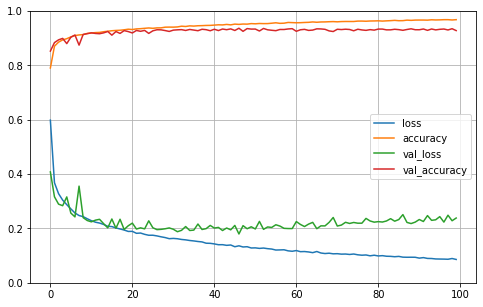

In [ ]:
pd.DataFrame(haar_nearest_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
haar_nearest.save_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/fashion_mnist/haar_nearest_fashion_mnist_last_epoch.h5')

### Haar-Bilinear

In [ ]:
haar_bilinear = build_fashion_mnist_model('haar', 'bilinear')

In [ ]:
haar_bilinear_history = train_model(haar_bilinear, 'haar', 'bilinear')

Epoch 1/100
782/782 [==============================] - 61s 73ms/step - loss: 0.6049 - accuracy: 0.7885 - val_loss: 0.6251 - val_accuracy: 0.7624
Epoch 2/100
782/782 [==============================] - 57s 73ms/step - loss: 0.3863 - accuracy: 0.8643 - val_loss: 0.4748 - val_accuracy: 0.8225
Epoch 3/100
782/782 [==============================] - 57s 72ms/step - loss: 0.3439 - accuracy: 0.8785 - val_loss: 0.3446 - val_accuracy: 0.8746
Epoch 4/100
782/782 [==============================] - 57s 73ms/step - loss: 0.3149 - accuracy: 0.8882 - val_loss: 0.2839 - val_accuracy: 0.8963
Epoch 5/100
782/782 [==============================] - 56s 71ms/step - loss: 0.2951 - accuracy: 0.8950 - val_loss: 0.3037 - val_accuracy: 0.8922
Epoch 6/100
782/782 [==============================] - 57s 72ms/step - loss: 0.2837 - accuracy: 0.8991 - val_loss: 0.2649 - val_accuracy: 0.9038
Epoch 7/100
782/782 [==============================] - 56s 71ms/step - loss: 0.2680 - accuracy: 0.9038 - val_loss: 0.2940 - val_ac

In [ ]:
haar_bilinear.evaluate(test_ds)

157/157 [==============================] - 4s 25ms/step - loss: 0.2870 - accuracy: 0.9229


[0.28702208399772644, 0.9229000210762024]

In [ ]:
haar_bilinear_saved = build_fashion_mnist_model('haar', 'bilinear')
haar_bilinear_saved.load_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/fashion_mnist/haar_bilinear_fashion_mnist.h5')
haar_bilinear_saved.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
haar_bilinear_saved.evaluate(test_ds)

157/157 [==============================] - 5s 24ms/step - loss: 0.2162 - accuracy: 0.9278


[0.21618710458278656, 0.9277999997138977]

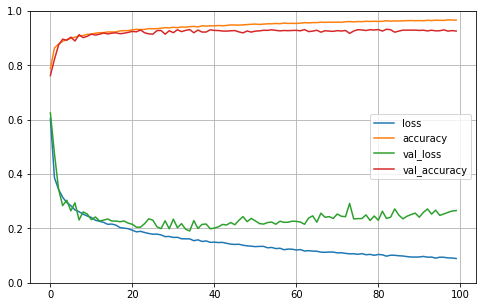

In [ ]:
pd.DataFrame(haar_bilinear_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
haar_bilinear.save_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/fashion_mnist/haar_bilinear_fashion_mnist_last_epoch.h5')

### DB2-Nearest

In [ ]:
db2_nearest = build_fashion_mnist_model('db2', 'nearest')

In [ ]:
db2_nearest_history = train_model(db2_nearest, 'db2', 'nearest')

Epoch 1/100
782/782 [==============================] - 69s 81ms/step - loss: 0.6373 - accuracy: 0.7750 - val_loss: 0.4375 - val_accuracy: 0.8395
Epoch 2/100
782/782 [==============================] - 62s 79ms/step - loss: 0.3866 - accuracy: 0.8639 - val_loss: 0.3499 - val_accuracy: 0.8701
Epoch 3/100
782/782 [==============================] - 63s 80ms/step - loss: 0.3370 - accuracy: 0.8811 - val_loss: 0.3202 - val_accuracy: 0.8774
Epoch 4/100
782/782 [==============================] - 62s 80ms/step - loss: 0.3109 - accuracy: 0.8900 - val_loss: 0.2976 - val_accuracy: 0.8940
Epoch 5/100
782/782 [==============================] - 62s 80ms/step - loss: 0.2926 - accuracy: 0.8975 - val_loss: 0.2480 - val_accuracy: 0.9114
Epoch 6/100
782/782 [==============================] - 62s 80ms/step - loss: 0.2762 - accuracy: 0.9027 - val_loss: 0.2833 - val_accuracy: 0.8985
Epoch 7/100
782/782 [==============================] - 62s 79ms/step - loss: 0.2669 - accuracy: 0.9056 - val_loss: 0.3677 - val_ac

In [ ]:
db2_nearest.evaluate(test_ds)

157/157 [==============================] - 5s 29ms/step - loss: 0.2803 - accuracy: 0.9254


[0.28032010793685913, 0.9254000186920166]

In [ ]:
db2_nearest_saved = build_fashion_mnist_model('db2', 'nearest')
db2_nearest_saved.load_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/fashion_mnist/db2_nearest_fashion_mnist.h5')
db2_nearest_saved.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
db2_nearest_saved.evaluate(test_ds)

157/157 [==============================] - 6s 28ms/step - loss: 0.2184 - accuracy: 0.9229


[0.21841982007026672, 0.9229000210762024]

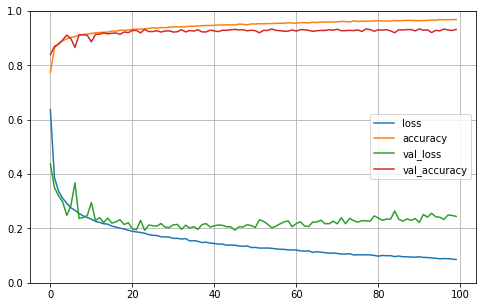

In [ ]:
pd.DataFrame(db2_nearest_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
db2_nearest.save_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/fashion_mnist/db2_nearest_fashion_mnist_last_epoch.h5')

### DB2-Bilinear

In [12]:
db2_bilinear = build_fashion_mnist_model('db2', 'bilinear')

In [13]:
db2_bilinear_history = train_model(db2_bilinear, 'db2', 'bilinear')

Epoch 1/100
782/782 [==============================] - 86s 83ms/step - loss: 0.6320 - accuracy: 0.7767 - val_loss: 0.3846 - val_accuracy: 0.8628
Epoch 2/100
782/782 [==============================] - 64s 81ms/step - loss: 0.3955 - accuracy: 0.8595 - val_loss: 0.3487 - val_accuracy: 0.8743
Epoch 3/100
782/782 [==============================] - 63s 80ms/step - loss: 0.3466 - accuracy: 0.8791 - val_loss: 0.4228 - val_accuracy: 0.8413
Epoch 4/100
782/782 [==============================] - 63s 80ms/step - loss: 0.3205 - accuracy: 0.8858 - val_loss: 0.4138 - val_accuracy: 0.8482
Epoch 5/100
782/782 [==============================] - 64s 81ms/step - loss: 0.3055 - accuracy: 0.8918 - val_loss: 0.2816 - val_accuracy: 0.9004
Epoch 6/100
782/782 [==============================] - 63s 80ms/step - loss: 0.2872 - accuracy: 0.8986 - val_loss: 0.3012 - val_accuracy: 0.8902
Epoch 7/100
782/782 [==============================] - 63s 81ms/step - loss: 0.2774 - accuracy: 0.9002 - val_loss: 0.2546 - val_ac

In [14]:
db2_bilinear.evaluate(test_ds)

157/157 [==============================] - 5s 29ms/step - loss: 0.2711 - accuracy: 0.9221


[0.27110782265663147, 0.9221000075340271]

In [15]:
db2_bilinear_saved = build_fashion_mnist_model('db2', 'bilinear')
db2_bilinear_saved.load_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/fashion_mnist/db2_bilinear_fashion_mnist.h5')
db2_bilinear_saved.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
db2_bilinear_saved.evaluate(test_ds)

157/157 [==============================] - 6s 27ms/step - loss: 0.2351 - accuracy: 0.9225


[0.23509036004543304, 0.9225000143051147]

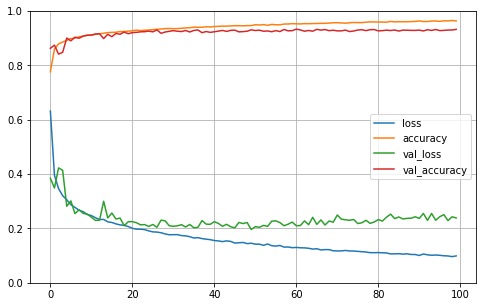

In [16]:
pd.DataFrame(db2_bilinear_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [17]:
db2_bilinear.save_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/fashion_mnist/db2_bilinear_fashion_mnist_last_epoch.h5')

### Fully Conv

In [18]:
fully_conv = Sequential([layers.Input(shape = (28, 28, 1), name = 'input'),
                      layers.RandomFlip(mode = 'horizontal', name = 'random_flip'),
                      layers.RandomRotation(factor = 10/360, name = 'random_rotation'),
                      layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_1'),
                      layers.BatchNormalization(name = 'conv2d_1_bn'),
                      layers.Activation('relu', name = 'conv2d_1_relu'),
                      layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_2'),
                      layers.BatchNormalization(name = 'conv2d_2_bn'),
                      layers.Activation('relu', name = 'conv2d_2_relu'),
                      layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), padding = 'same', name = 'conv2d_3'),
                      layers.BatchNormalization(name = 'conv2d_3_bn'),
                      layers.Activation('relu', name = 'conv2d_3_relu'),
                      layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_4'),
                      layers.BatchNormalization(name = 'conv2d_4_bn'),
                      layers.Activation('relu', name = 'conv2d_4_relu'),
                      layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_5'),
                      layers.BatchNormalization(name = 'conv2d_5_bn'),
                      layers.Activation('relu', name = 'conv2d_5_relu'),
                      layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_6'),
                      layers.BatchNormalization(name = 'conv2d_6_bn'),
                      layers.Activation('relu', name = 'conv2d_6_relu'),
                      layers.Conv2D(filters = 128, kernel_size = (3,3), strides = (2,2), padding = 'same', name = 'conv2d_7'),
                      layers.BatchNormalization(name = 'conv2d_7_bn'),
                      layers.Activation('relu', name = 'conv2d_7_relu'),
                      layers.GlobalAveragePooling2D(name = 'avgpooling'),
                      layers.Dropout(0.5, name = 'dropout'),
                      layers.Dense(units = 10, activation = 'softmax', name = 'predictions')],
                     name = f'fully_conv_model')

In [19]:
fully_conv.summary()

Model: "fully_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 28, 28, 1)         0         
                                                                 
 random_rotation (RandomRota  (None, 28, 28, 1)        0         
 tion)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_1_bn (BatchNormaliza  (None, 28, 28, 32)       128       
 tion)                                                           
                                                                 
 conv2d_1_relu (Activation)  (None, 28, 28, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)   

In [20]:
optimizer = tf.keras.optimizers.Adam(0.001)
fully_conv.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
dir_model = 'GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/fashion_mnist/fully_conv_fashion_mnist.h5'
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(dir_model, save_best_only = True)
with tf.device('/device:GPU:0'):
  fully_conv_history = fully_conv.fit(
                        x = train_ds,
                        epochs = 100, 
                        callbacks = [checkpoint_cb],
                        validation_data = val_ds
                        )

Epoch 1/100
782/782 [==============================] - 20s 23ms/step - loss: 0.6286 - accuracy: 0.7762 - val_loss: 0.5608 - val_accuracy: 0.8046
Epoch 2/100
782/782 [==============================] - 18s 23ms/step - loss: 0.4006 - accuracy: 0.8581 - val_loss: 0.3372 - val_accuracy: 0.8710
Epoch 3/100
782/782 [==============================] - 19s 24ms/step - loss: 0.3461 - accuracy: 0.8779 - val_loss: 0.2970 - val_accuracy: 0.8931
Epoch 4/100
782/782 [==============================] - 18s 23ms/step - loss: 0.3123 - accuracy: 0.8904 - val_loss: 0.3281 - val_accuracy: 0.8811
Epoch 5/100
782/782 [==============================] - 18s 23ms/step - loss: 0.2869 - accuracy: 0.8982 - val_loss: 0.2545 - val_accuracy: 0.9045
Epoch 6/100
782/782 [==============================] - 18s 24ms/step - loss: 0.2782 - accuracy: 0.9032 - val_loss: 0.2405 - val_accuracy: 0.9130
Epoch 7/100
782/782 [==============================] - 19s 24ms/step - loss: 0.2616 - accuracy: 0.9080 - val_loss: 0.2250 - val_ac

In [21]:
fully_conv.evaluate(test_ds)

157/157 [==============================] - 1s 9ms/step - loss: 0.2882 - accuracy: 0.9272


[0.28816255927085876, 0.9272000193595886]

In [22]:
fully_conv_saved = keras.models.load_model('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/fashion_mnist/fully_conv_fashion_mnist.h5')
fully_conv_saved.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
fully_conv_saved.evaluate(test_ds)

157/157 [==============================] - 2s 9ms/step - loss: 0.1967 - accuracy: 0.9326


[0.19665135443210602, 0.9326000213623047]

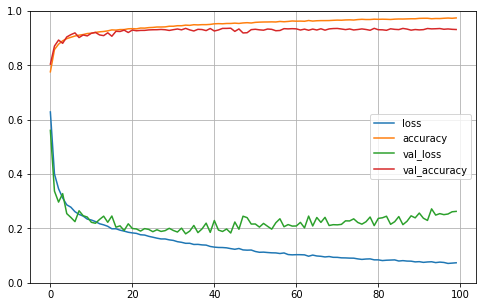

In [23]:
pd.DataFrame(fully_conv_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [24]:
fully_conv.save_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/fashion_mnist/fully_conv_fashion_mnist_last_epoch.h5')